In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
import datetime as dt
import pickle

from utils import processing
from utils import utils

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, \
    BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import wandb
from wandb.keras import WandbCallback


In [2]:
random.seed(hash("random seed") % 2**32 - 1)
np.random.seed(hash("numpy seed") % 2**32 - 1)
tf.random.set_seed(hash("tensorflow seed") % 2**32 - 1)

In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,12)

In [4]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
kld = kld[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]
stb = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = stb[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]

In [5]:
# Processing Parameters
steps = 1 # timesteps: 1 hour
num_features = 9

lookback = 744 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 224
epochs = 50
lr = 0.04

In [6]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.ts_offset_split(kld, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.ts_offset_split(stb, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [7]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (224, 744, 9)
Target Shape: (224, 1)


# LSTM: Kolding Dataset

In [8]:
# LSTM Benchmark
LSTM_base_kld = Sequential()
LSTM_base_kld.add(Input(shape=(lookback, num_features)))

LSTM_base_kld.add(LSTM(96, return_sequences=False, activation='tanh'))
LSTM_base_kld.add(Dropout(0.2))

LSTM_base_kld.add(Dense(1))

LSTM_base_kld.compile(optimizer=SGD(momentum=0.9, learning_rate=lr), loss="mse", metrics=['mae'])

LSTM_base_kld.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96)                40704     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Callbacks
estp = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, verbose=1)

ckpt_path = "../model/models/LSTM_benchmark_kld.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


In [10]:
history_kld = LSTM_base_kld.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
66/66 [==============================] - 189s 3s/step - loss: 0.6295 - mae: 0.6104 - val_loss: 0.4412 - val_mae: 0.5067

Epoch 00001: val_loss improved from inf to 0.44124, saving model to ../model/models\LSTM_benchmark_kld.h5
Epoch 2/50
66/66 [==============================] - 174s 3s/step - loss: 0.3675 - mae: 0.4486 - val_loss: 0.3168 - val_mae: 0.4249

Epoch 00002: val_loss improved from 0.44124 to 0.31678, saving model to ../model/models\LSTM_benchmark_kld.h5
Epoch 3/50
66/66 [==============================] - 189s 3s/step - loss: 0.2630 - mae: 0.3856 - val_loss: 0.2209 - val_mae: 0.3553

Epoch 00003: val_loss improved from 0.31678 to 0.22093, saving model to ../model/models\LSTM_benchmark_kld.h5
Epoch 4/50
66/66 [==============================] - 197s 3s/step - loss: 0.1924 - mae: 0.3328 - val_loss: 0.1962 - val_mae: 0.3481

Epoch 00004: val_loss improved from 0.22093 to 0.19622, saving model to ../model/models\LSTM_benchmark_kld.h5
Epoch 5/50
66/66 [==================

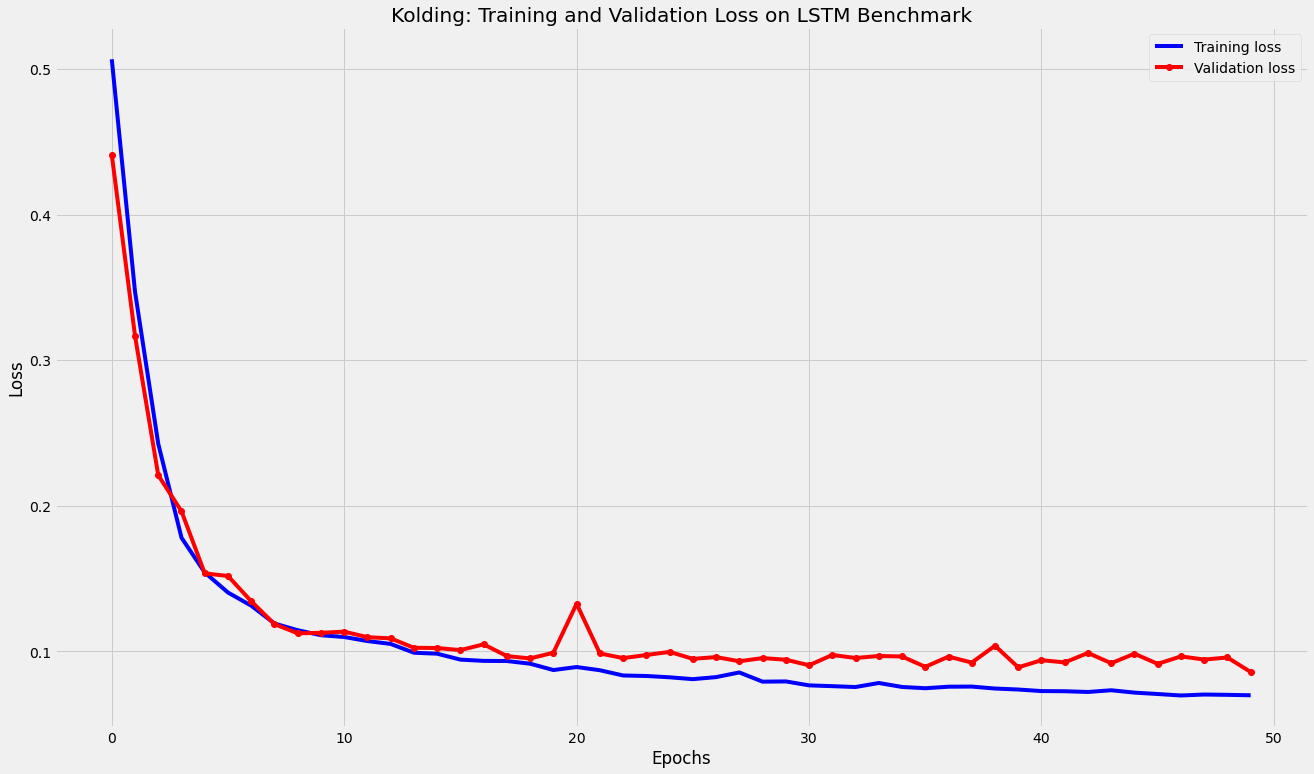

In [11]:
utils.plot_training(history_kld, "Kolding: Training and Validation Loss on LSTM Benchmark")

In [12]:
kld_eval = LSTM_base_kld.evaluate(kld_test)

12/12 [==============================] - 1s 110ms/step - loss: 0.1148 - mae: 0.2529


In [13]:
kld_std = 31.31291841
print(f'Inverse Scaled MAE: {round(kld_eval[1] * kld_std, 2)}')

Inverse Scaled MAE: 7.92


# LSTM: Middelfart Dataset

In [12]:
for batch in stb_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (224, 744, 9)
Target Shape: (224, 1)


In [13]:
# LSTM Benchmark
LSTM_base_stb = Sequential()

LSTM_base_stb.add(Input(shape=(lookback, num_features)))

LSTM_base_stb.add(LSTM(96, return_sequences=False, activation='tanh'))
LSTM_base_stb.add(Dropout(0.2))

LSTM_base_stb.add(Dense(1))

LSTM_base_stb.compile(optimizer=SGD(momentum=0.9, learning_rate=lr), loss="mse", metrics=['mae'])

LSTM_base_stb.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 96)                40704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________


In [14]:
estp = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5)

ckpt_path = "../model/models/LSTM_benchmark_stb.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


In [15]:
history_stb = LSTM_base_stb.fit(
    stb_train,
    epochs=epochs,
    validation_data=stb_val,
    callbacks=[estp, ckpt, reduce_lr]
)

Epoch 1/50
66/66 [==============================] - 233s 3s/step - loss: 0.7158 - mae: 0.6515 - val_loss: 0.4617 - val_mae: 0.4994

Epoch 00001: val_loss improved from inf to 0.46171, saving model to ../model/models\LSTM_benchmark_stb.h5
Epoch 2/50
66/66 [==============================] - 234s 4s/step - loss: 0.3733 - mae: 0.4514 - val_loss: 0.3650 - val_mae: 0.4506

Epoch 00002: val_loss improved from 0.46171 to 0.36503, saving model to ../model/models\LSTM_benchmark_stb.h5
Epoch 3/50
66/66 [==============================] - 232s 4s/step - loss: 0.3194 - mae: 0.4205 - val_loss: 0.2466 - val_mae: 0.3794

Epoch 00003: val_loss improved from 0.36503 to 0.24656, saving model to ../model/models\LSTM_benchmark_stb.h5
Epoch 4/50
66/66 [==============================] - 245s 4s/step - loss: 0.2241 - mae: 0.3619 - val_loss: 0.1674 - val_mae: 0.3157

Epoch 00004: val_loss improved from 0.24656 to 0.16739, saving model to ../model/models\LSTM_benchmark_stb.h5
Epoch 5/50
66/66 [==================

KeyboardInterrupt: 

In [ ]:
utils.plot_training(history_stb, "Middelfart: Training and Validation Loss on LSTM Benchmark")

In [19]:
stb_eval = LSTM_base_stb.evaluate(stb_test)

12/12 [==============================] - 1s 76ms/step - loss: 0.1367 - mae: 0.2795


In [20]:
stb_std = 18.33954707
print(f'Inverse Scaled MAE: {round(stb_eval[1] * stb_std, 2)}')

Inverse Scaled MAE: 5.13
